In [1]:
%pylab inline
#%matplotlib notebook
import glob
import os
import imp
import scipy.signal as sig
from matplotlib import image as im
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import ticker
#import pywt 
from scipy import ndimage
from numpy import fft
#from pywt import thresholding as thr
#import nbsp
#exec(compile(open('/home/nicolas/Documentos/Universidad/Sources/Fluorescencia semi_inf/FlDPDW.py').read()))
import re

Populating the interactive namespace from numpy and matplotlib


In [2]:
def load_imagesWFR (path, query):
    files = glob.glob(path + query)
    files.sort()
    retArr = dict()
    ascs = []
    sources = set()
    angles = set()
    for i in files:
        listProp = []
        filename = os.path.basename(i)
        listRawProp = re.split("['_a','_s',.]+", filename)
        print(listRawProp)
        for j in range(len(listRawProp)):
            try:
                number = int(listRawProp[j])
                listProp.append(number)
            except:
                pass
        retArr[int(listProp[0]), int(listProp[1])] = ndimage.zoom(np.genfromtxt(i), order=0, zoom=1)
    print("Archivos cargados: " + str(len(retArr)))
    for key, value in retArr.items() :
        sources.add(int(key[0]))
        angles.add(int(key[1]))
    print("Sources: ", sources)
    print("Angles: ", angles)
    return retArr, sources, angles

In [3]:
def fft_gauss (in_array, kernel_size):
    """Perform FFR Gauss low-pass filtering
    in_array: input image
    kernel_size: kernel size for smoothing
    """
    
    # FFT filter
    im_fft = fft.rfftn(in_array)
    im_rfft_filtered = ndimage.fourier_gaussian(im_fft, kernel_size, in_array.shape[1])
    im_filtered = fft.irfftn(im_rfft_filtered)
    
    #Power spectrum       
    pwr_spectrum = abs(fft.fftshift(im_fft))**2
    pwr_spectrum_filtered = abs(fft.fftshift(im_rfft_filtered))**2
        
    #Re-normalization
    sum_ratio= in_array.sum()/im_filtered.sum()
    im_filtered = im_filtered*sum_ratio
    
    return im_filtered, pwr_spectrum, pwr_spectrum_filtered

In [4]:
from scipy import interpolate 
import math
def to_XY(rdArray, dr, Nr, dx, Nx, dy, Ny, x0, y0):
    xyArray = np.zeros((Nx,Ny), float)
    for x in range(Nx):
        for y in range(Ny):
            xPos = (x+0.5-Nx/2)*dx
            yPos = (y+0.5-Ny/2)*dy
            rXy2 = (xPos-x0)**2 + (yPos-y0)**2
            if rXy2 < (Nr*dr)**2:
                rInterpolated = interpolate.interp1d([row[0] for row in colArray],[row[1] for row in colArray])
                xyArray[x][y] = rInterpolated(math.sqrt(rXy2)) #* (1-1*math.exp(math.sqrt(1/(r_xy2-x0))))
            else:
                xyArray[x][y] = 1.
    print(np.shape(xyArray))
    fig = plt.figure()
    plt.imshow(xyArray)
    return xyArray

['jnir', '-noIM-z1', '0', '10', 'd', 't', 'Refl', 'd', 't']
['jnir', '-noIM-z1', '0', '100', 'd', 't', 'Refl', 'd', 't']
['jnir', '-noIM-z1', '0', '110', 'd', 't', 'Refl', 'd', 't']
['jnir', '-noIM-z1', '0', '120', 'd', 't', 'Refl', 'd', 't']
['jnir', '-noIM-z1', '0', '130', 'd', 't', 'Refl', 'd', 't']
['jnir', '-noIM-z1', '0', '140', 'd', 't', 'Refl', 'd', 't']
['jnir', '-noIM-z1', '0', '150', 'd', 't', 'Refl', 'd', 't']
['jnir', '-noIM-z1', '0', '160', 'd', 't', 'Refl', 'd', 't']
['jnir', '-noIM-z1', '0', '170', 'd', 't', 'Refl', 'd', 't']
['jnir', '-noIM-z1', '0', '180', 'd', 't', 'Refl', 'd', 't']
['jnir', '-noIM-z1', '0', '190', 'd', 't', 'Refl', 'd', 't']
['jnir', '-noIM-z1', '0', '20', 'd', 't', 'Refl', 'd', 't']
['jnir', '-noIM-z1', '0', '200', 'd', 't', 'Refl', 'd', 't']
['jnir', '-noIM-z1', '0', '210', 'd', 't', 'Refl', 'd', 't']
['jnir', '-noIM-z1', '0', '220', 'd', 't', 'Refl', 'd', 't']
['jnir', '-noIM-z1', '0', '230', 'd', 't', 'Refl', 'd', 't']
['jnir', '-noIM-z1', '0', 

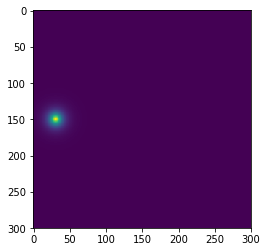

In [14]:
# Load MC images

#path="/home/nicolas/Documentos/Universidad/Simulaciones/Jnirs/newCode/noIM-b/"
path="/home"
images, sources, angles = load_imagesWFR(path, "*_Refl.dat")
sources = sorted(sources)
angles = sorted(angles)
imshow(images[0,120])

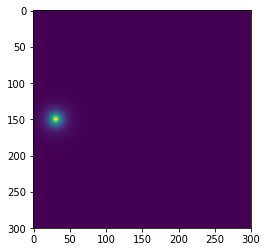

In [15]:
imshow(images[0,300])

(300, 300)


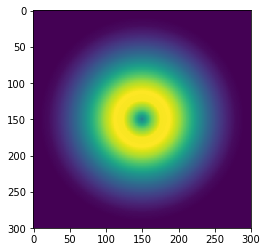

In [16]:
NpointsInc = 40
MaxDistance = 20
colArray=np.loadtxt("/home/nicolas/Documentos/Universidad/Sources/Fluorescencia semi_inf/teo_sens_z2.0.dat")
XY_Prof_Sens = dict()
for itemS in sources:
    XY_Prof_Sens[itemS]=(to_XY (colArray, MaxDistance/NpointsInc, NpointsInc, 0.04, 300, 0.04, 300, 0, float(itemS))-1)
    #imshow(XY_Prof_Sens[xs])

In [19]:
#sources = {'2','3'}

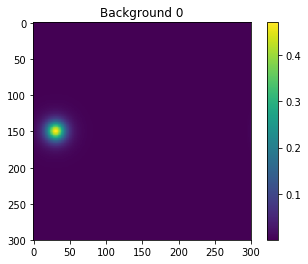

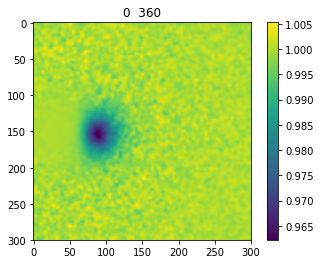

In [17]:
# Create background and divide
min_mods=[]
imagesDiv=dict()
back = dict()
fondito=1e-04
mod360=0.0461138493088

for itemS in sources:
    backTemp=np.full((300,300),0, dtype=float)
    divTemp=np.full((300,300),0, dtype=float)
    for itemA in angles:
        backTemp += images[itemS,itemA]
    back[itemS] = backTemp/len(angles)
    plt.title("Background " + str(itemS))
    plt.imshow(fft_gauss(back[itemS], 5)[0])
    cbar = plt.colorbar()
    for itemA in angles:
        imagesDiv[itemS,itemA] = (images[itemS,itemA]+fondito)/(back[itemS]+fondito)
        #divTemp = [x if (not np.isnan(x)) else 1 for x in divTemp]
        if itemA == 360: 
            fig = plt.figure()
            plt.title(str(itemS)+"  "+str(itemA))
            plt.imshow(fft_gauss(imagesDiv[itemS,itemA], 0)[0])
            plt.imshow(fft_gauss(ndimage.rotate(imagesDiv[itemS,itemA], angle=float(itemA), reshape=False, order=1, cval=1), 2)[0])
            cbar = plt.colorbar()
        np.savetxt(path+"div_"+str(itemA)+".dat", imagesDiv[itemS,itemA])
        min_mod = np.amin(fft_gauss(imagesDiv[itemS,itemA][:,0:200], 10)[0])
        min_mods.append((1-min_mod))
        if (itemA==360):
            mod360=1-min_mod



[[  1.00000000e+01   5.46071004e-01]
 [  2.00000000e+01   4.08837566e-01]
 [  3.00000000e+01   2.77691992e-01]
 [  4.00000000e+01   1.46365833e-01]
 [  5.00000000e+01   8.92302525e-02]
 [  6.00000000e+01   6.54950356e-02]
 [  7.00000000e+01   4.20468931e-02]
 [  8.00000000e+01   1.88566212e-02]
 [  9.00000000e+01   1.34455631e-02]
 [  1.00000000e+02   1.60633263e-02]
 [  1.10000000e+02   1.78153045e-02]
 [  1.20000000e+02   2.00709424e-02]
 [  1.30000000e+02   1.99135847e-02]
 [  1.40000000e+02   1.50551418e-02]
 [  1.50000000e+02   1.46149046e-02]
 [  1.60000000e+02   1.21205889e-02]
 [  1.70000000e+02   1.30337462e-02]
 [  1.80000000e+02   1.30299305e-02]
 [  1.90000000e+02   1.41115428e-02]
 [  2.00000000e+02   1.28145236e-02]
 [  2.10000000e+02   1.35181599e-02]
 [  2.20000000e+02   1.06440139e-02]
 [  2.30000000e+02   1.45037476e-02]
 [  2.40000000e+02   1.49398351e-02]
 [  2.50000000e+02   1.76647154e-02]
 [  2.60000000e+02   2.00362402e-02]
 [  2.70000000e+02   2.63517906e-02]
 

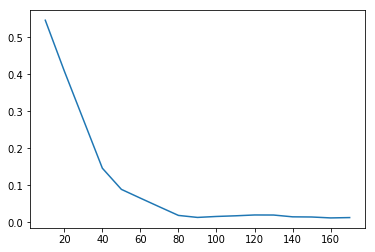

In [18]:
mod360=0.0461138493088
min_mods_norm = [x/mod360 for x in min_mods]
data=vstack([angles,min_mods_norm]).T
print(data)
np.savetxt(path+"mods.dat", data)
plot(angles[0:17],min_mods_norm[0:17])
print(min_mods_norm[0],min_mods_norm[1], mod360)

In [83]:
angles[0:17]

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170]

In [84]:
# Rotate and add to final image

resultIm = np.full((250,250),0, dtype=float)
sensAdd = np.full((250,250),0., dtype=float)
for itemS in sources:
    resultImS = np.full((250,250),0, dtype=float)
    sensAddS = np.full((250,250),0, dtype=float)
    for itemA in angles:
        ProfSensRot = ndimage.rotate(XY_Prof_Sens[itemS], angle=itemA, reshape=False, order=1, cval=10e-10)
        resultImS +=ndimage.rotate(imagesDiv[itemS,itemA], angle=itemA, reshape=False, order=1, cval=1)*ProfSensRot#*(itemS+1)
        sensAddS += ProfSensRot#*(itemS+1)
    resultIm += resultImS
    sensAdd += sensAddS
    fig = plt.figure()
    plt.title(str(itemS))
    plt.imshow(fft_gauss(resultImS/sensAddS, 5)[0])
    cbar = plt.colorbar()
resultIm = resultIm/sensAdd

ValueError: operands could not be broadcast together with shapes (250,250) (300,300) (250,250) 

In [7]:
fig = plt.figure()
plt.imshow(fft_gauss(resultIm, 5)[0])
cbar = plt.colorbar()
cbar.set_label("Normalizad intensity")
tick_locator = ticker.MaxNLocator(nbins=4)
cbar.locator = tick_locator
cbar.update_ticks()
plt.axis('image')
#fig.savefig(path + "trans6_rot_+.png" )

NameError: name 'resultIm' is not defined

In [11]:
# Rotate and add to final image

resultIm = np.full((250,250),0, dtype=float)
resultRotS = np.full((len (angles),250,250),0, dtype=float)
senS = np.full((len (angles),250,250),0, dtype=float)

sensAdd = np.full((250,250),0., dtype=float)
for itemS in sources:
    sensAddS = np.full((250,250),0.000001, dtype=float)
    iA = 0
    resultImS = np.full((250,250),0, dtype=float)
    maxS = 200
    for itemA in angles:
        senS[iA] = ndimage.rotate(XY_Prof_Sens[itemS], angle=-itemA, reshape=False, order=1, cval=0)
        resultRotS[iA] = ndimage.rotate(imagesDiv[itemS,itemA], angle=itemA, reshape=False, order=1, cval=1)#*(senS[iA])
        sensAddS+=(senS[iA])
        iA+=1
    resultImS = np.median(resultRotS*senS, axis=0)
    resultIm += resultImS*XY_Prof_Sens[itemS]
    #fig = plt.figure()
    #sensAdd += sensAddS
    #plt.title(str(itemS))
    #plt.imshow(fft_gauss(resultImS/(np.average(senS, axis=0)), 10, resultIm.shape)[0], vmin=0.99)
    #cbar = plt.colorbar()
resultIm = resultIm#/sensAdd


In [ ]:
plt.imshow(np.average(senS))
cbar = plt.colorbar()


In [ ]:
resultImFFT=fft_gauss(resultIm, 2, resultIm.shape)[0]
imshow(resultImFFT, vmax=1.01)
cbar = plt.colorbar()

In [ ]:
resultImFFT=fft_gauss(resultIm, 2, resultIm.shape)[0]
imshow(resultImFFT, vmin=0.95,)
cbar = plt.colorbar()

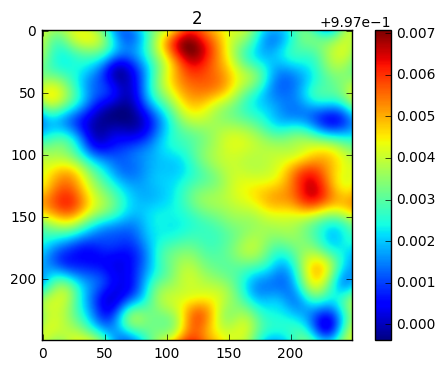

In [177]:
# Rotate and add to final image

resultIm = np.full((250,250),0, dtype=float)
sensAdd = np.full((250,250),0., dtype=float)
for itemS in sources:
    resultImS = np.full((250,250),0, dtype=float)
    sensAddS = np.full((250,250),0.000001, dtype=float)
    for itemA in angles:
        ProfSensRot = ndimage.rotate(XY_Prof_Sens[itemS], angle=-itemA, reshape=False, order=1, cval=0)
        resultImS +=ndimage.rotate(imagesDiv[itemS,itemA], angle=itemA, reshape=False, order=1, cval=1)
        sensAddS += 1
    resultIm += resultImS
    sensAdd += sensAddS
    fig = plt.figure()
    plt.title(str(itemS))
    plt.imshow(fft_gauss(resultImS/sensAddS, 10, resultIm.shape)[0])
    cbar = plt.colorbar()
resultIm = resultIm/sensAdd


In [178]:
resultImFlatFFT=fft_gauss(resultImFlat, 2, resultImFlat.shape)[0]
imshow(resultImFlatFFT)
cbar = plt.colorbar()

NameError: name 'resultImFlat' is not defined